# Custom Embeddings using movie reviews dataset

    - Get all documents in list
    - Has each document to get it's sequence
    - Pass each document so that they are all of same size
    - Create a Sequential Model
    - Add Embedding layer which takes 
        - size of vocab
        - desired dimensions of embeddings
        - size of input sequences
    - Once we train the model we can save the embeddings layer for use later
    
    This notebook assumes that you have the imdb reviews downloaded in unzipped in a directory called imdb along with the notebook. If not then please download the reviews.

In [1]:
import os
import random

imdb_dir = './imdb/train'
reviews = []
labels = []

def read_reviews_label (imdb_dir, label):
    dir_name = os.path.join(imdb_dir, label)
    
    for fname in os.listdir(dir_name):
        if (fname[-4:]=='.txt'):
            f = open (os.path.join(dir_name, fname), encoding='utf-8', mode='r')
            review = f.read()
            reviews.append(review)
            f.close()
            if (label == 'pos'):
                labels.append(1)
            if (label == 'neg'):
                labels.append(0)
                
#read positive & negative reviews
read_reviews_label(imdb_dir, 'pos')
read_reviews_label(imdb_dir, 'neg')

#shuffle the reviews and labels list together so that we have a good mix
mapIndexPosition = list(zip(reviews, labels))
random.shuffle(mapIndexPosition)
reviews, labels = zip(*mapIndexPosition)

print ('Number of reviews is %d'%(len(reviews)))
print ('Number of labels is %d'%(len(labels)))

Number of reviews is 25000
Number of labels is 25000


### Step 1: - Tokenize and Create Vocab

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

labels = np.array(labels)
#define the overall size of vocabulary taking into account all the reviews
max_words = 9999

# tokenize all reviews into tokens where each token represents a word. here we are restricting number of tokens to 9999
def tokenize_document(p_reviews, max_words):
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(p_reviews)
    
    sequences = tokenizer.texts_to_sequences(p_reviews)
    print ('Number of sequences is ', len(sequences))
    
    word_index  = tokenizer.word_index
    
    return (word_index, sequences)

(word_index, sequences) = tokenize_document(reviews, max_words)

words_per_review = 999
# pad each sequence so that each sequence (which represents one review) has same shape.
def pad_documents (sequences, words_per_review):
    padded_reviews = pad_sequences (sequences, maxlen=words_per_review, padding='post')
    return padded_reviews

padded_reviews = pad_documents(sequences, words_per_review)

print ('Vocabulary size is %d and size of padded reviews is %s'%(len(word_index), padded_reviews.shape))

Using TensorFlow backend.


Number of sequences is  25000
Vocabulary size is 88582 and size of padded reviews is (25000, 999)


### Step 2: - Define Model

In [4]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.utils.vis_utils import plot_model

model = Sequential()
model.add(Embedding(input_dim=len(word_index)+1, output_dim=100, input_length=(words_per_review)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

#plot model and save as png file
#plot_model(model, to_file='reviews_embedding_model.png', show_shapes=True)

#fit the model on training data
history = model.fit (padded_reviews, labels, validation_split=0.3, epochs=5, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 999, 100)          8858300   
_________________________________________________________________
flatten_2 (Flatten)          (None, 99900)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 99901     
Total params: 8,958,201
Trainable params: 8,958,201
Non-trainable params: 0
_________________________________________________________________
Train on 17500 samples, validate on 7500 samples
Epoch 1/5
17500/17500 [==============================] - 107s 6ms/step - loss: 0.4574 - acc: 0.7715 - val_loss: 0.3347 - val_acc: 0.8519
Epoch 2/5
17500/17500 [==============================] - 107s 6ms/step - loss: 0.1648 - acc: 0.9431 - val_loss: 0.2883 - val_acc: 0.8828
Epoch 3/5
17500/17500 [==============================] - 107s 6ms/step - 

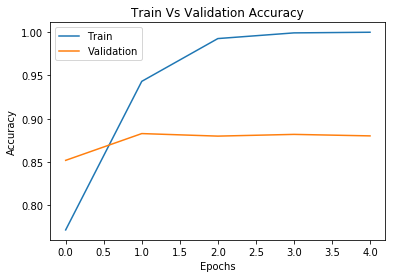

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

## Visualizing Model Accuracy on Training & Validation data
trainAccHistory = history.history['acc']
validationAccHistory = history.history['val_acc']

plt.plot(trainAccHistory)
plt.plot(validationAccHistory)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train Vs Validation Accuracy')
plt.legend(['Train','Validation'])
plt.show()

### Step 4 - Create Matrix of Word Embeddings in our Vocab

    - Read words from our word dictionary
    - Read the embeddings weights from the embedding layer
    - For each word in the dictionary read it's embedding weight and add to a dictionary

In [6]:
import numpy as np
embeddings_index = {}

# get weights from the embedding layer
embeddings = model.layers[0].get_weights()[0]

print ('Shape of weights from embedding layer is ', embeddings.shape)
print ('Size of vocab is ', len(word_index))

for word, i in word_index.items():
    if (i<len(embeddings)):
        embeddings_index[word] =  embeddings[i]

Shape of weights from embedding layer is  (88583, 100)
Size of vocab is  88582


#### Save the Reviews Embedding

In [7]:
def save_list (p_embeddings, filename):
    #open file
    file = open (filename, 'w', encoding='utf-8')
    
    for key, value in p_embeddings.items():
        word = key + ' '
        we = ''
        for val in value:
            embedding = str(val)
            we = we + embedding + ' '
        
        embedding = word + we + '\n'
        
        #write embedding to file
        file.write(embedding)
    
    #close file
    file.close()
    
save_list(embeddings_index, 'custom.movie.reviews.embeddings.100D.txt')

#### Reload the saved embeddings and train model using it

In [8]:
embedding_dir = './'
loaded_embeddings_matrix = {}

f = open ('custom.movie.reviews.embeddings.100D.txt','r', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    loaded_embeddings_matrix[word]=coefs

f.close()
print ('Found %s word embeddings'%(len(loaded_embeddings_matrix)))

Found 88078 word embeddings


#### Retrain model on loaded embeddings

In [9]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.utils.vis_utils import plot_model

loaded_model = Sequential()
loaded_model.add(Embedding(input_dim=(len(word_index)+1), output_dim=100, input_length=(words_per_review)))
loaded_model.add(Flatten())

loaded_model.layers[0].set_weights = ([loaded_embeddings_matrix])
loaded_model.layers[0].trainable = False

loaded_model.add(Dense(1, activation='sigmoid'))
loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
loaded_model.summary()

#plot model and save as png file
#plot_model(model, to_file='reviews_embedding_model.png', show_shapes=True)

#fit the model on training data
history = loaded_model.fit (padded_reviews, labels, validation_split=0.3, epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 999, 100)          8858300   
_________________________________________________________________
flatten_3 (Flatten)          (None, 99900)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 99901     
Total params: 8,958,201
Trainable params: 99,901
Non-trainable params: 8,858,300
_________________________________________________________________
Train on 17500 samples, validate on 7500 samples
Epoch 1/50
17500/17500 [==============================] - 8s 445us/step - loss: 0.7149 - acc: 0.5206 - val_loss: 0.6871 - val_acc: 0.5203
Epoch 2/50
17500/17500 [==============================] - 7s 414us/step - loss: 0.6491 - acc: 0.6230 - val_loss: 0.7044 - val_acc: 0.5220
Epoch 3/50
17500/17500 [==============================] - 7s 415us

# Leverage Embeddings to find similar words

In [10]:
from gensim.scripts.glove2word2vec import glove2word2vec

#load the GloVe word embeddings file which has a 100 dimension representation for each word. Convert that into a word2vec supported format
glove2word2vec('custom.movie.reviews.embeddings.100D.txt','word2vec.custom.movie.reviews.embeddings.100D.txt')

(88582, 100)

In [11]:
from gensim.models import KeyedVectors

# load the wordvec file
model = KeyedVectors.load_word2vec_format('word2vec.custom.movie.reviews.embeddings.100D.txt')

In [13]:
# most similar words
print (model.most_similar(positive=['nice'], negative=['awful']))

[('rare', 0.9228371381759644), ('voight', 0.9076741337776184), ('gem', 0.9050614237785339), ('lonely', 0.9041692018508911), ('wonderfully', 0.9006940126419067), ('ruby', 0.8986232280731201), ('delightful', 0.8982964754104614), ('finest', 0.8936723470687866), ('victoria', 0.8925464153289795), ('excellently', 0.8922926187515259)]


#### Visualize embeddings using PCA

    - In tour word embedding there are some 80K words with 100 dimensional embedding. We will select just 50 words and try to visualize them after doing a dimension reduction via PCA

C:\MachineLearning\anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


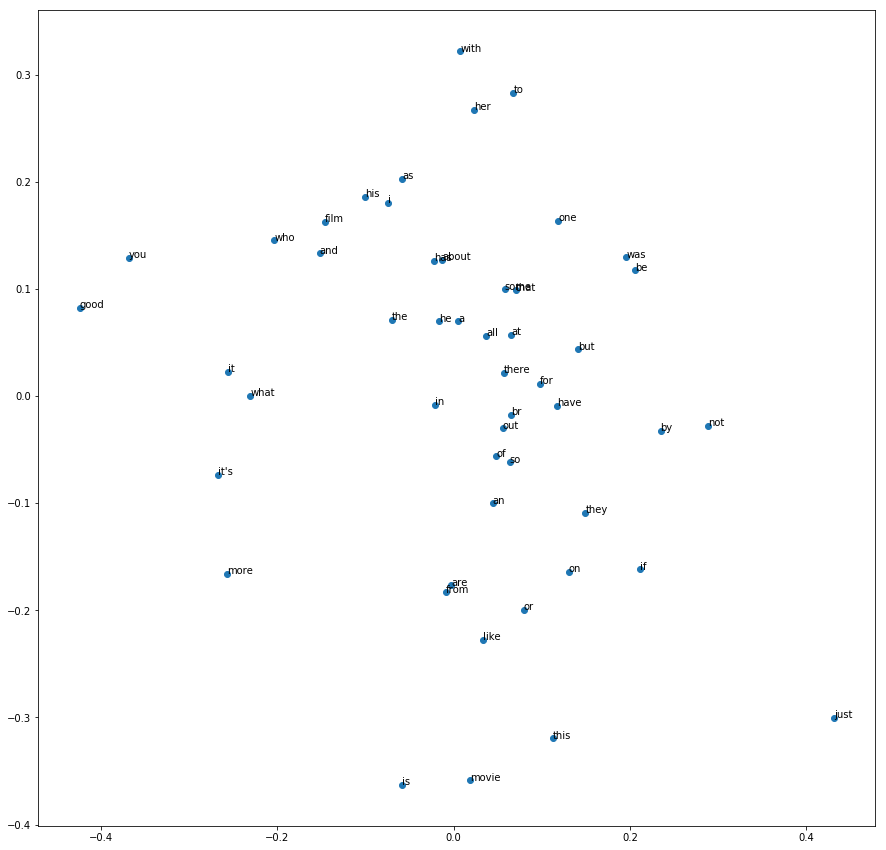

In [16]:
vocab = model.wv.vocab
words = []
for i, word in enumerate(vocab):
    words.append(word)

X = model[vocab]

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

z = PCA(n_components=2)
pca_model = z.fit(X)
components = pca_model.transform(X)

num_words_to_show=50

plt.figure(figsize=(15,15))
plt.scatter(components[0:num_words_to_show,0],components[0:num_words_to_show,1])
for i in range(0, num_words_to_show):
    plt.annotate(words[i], xy=(components[i,0],components[i,1]))
plt.show()